In [1]:
# Install missing packages (runs only when package is not already available)
%pip install -q tensorflow matplotlib

# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Path setup
train_dir = '../datasets/train'
val_dir   = '../datasets/val'

print("Training images from:", train_dir)
print("Validation images from:", val_dir)


Training images from: ../datasets/train
Validation images from: ../datasets/val


In [3]:
# 3️⃣ Data preprocessing & augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# 4️⃣ Load pretrained VGG16 (feature extractor)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()  


2025-11-07 20:08:52.353934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-11-07 20:08:52.354109: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-07 20:08:52.354119: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-07 20:08:52.354423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-07 20:08:52.354451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 5️⃣ Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

print("Trainable layers after freezing:", sum([l.trainable for l in base_model.layers]))


Trainable layers after freezing: 0


In [6]:
# 6️⃣ Add custom classifier head
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# 7️⃣ Train model
history = model.fit(
    train_generator,
    epochs=10,              
    validation_data=val_generator
)


Epoch 1/10


2025-11-07 20:08:59.330457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 297ms/step - accuracy: 0.8005 - loss: 0.5181 - val_accuracy: 0.9222 - val_loss: 0.1995
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 286ms/step - accuracy: 0.8605 - loss: 0.3780 - val_accuracy: 0.9188 - val_loss: 0.2031
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 178s 284ms/step - accuracy: 0.8729 - loss: 0.3641 - val_accuracy: 0.9312 - val_loss: 0.1803
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 282ms/step - accuracy: 0.8781 - loss: 0.3488 - val_accuracy: 0.9318 - val_loss: 0.1809
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 288ms/step - accuracy: 0.8845 - loss: 0.3336 - val_accuracy: 0.9340 - val_loss: 0.1735
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 297ms/step - accuracy: 0.8877 - loss: 0.3219 - val_accuracy: 0.9264 - val_loss: 0.1989
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 320ms/step - accuracy: 0.8904 - loss: 0.3178 - val_accuracy: 0.9298 - val_loss: 0.1980
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 313ms/step - accuracy: 0.8966 - loss: 0.29

In [8]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)


Train samples: 20000
Validation samples: 5000


In [14]:
model.save('best_model.keras')
print("✅ Model saved successfully!")



✅ Model saved successfully!


✅ Model saved to ../models/vgg16_catdog.h5


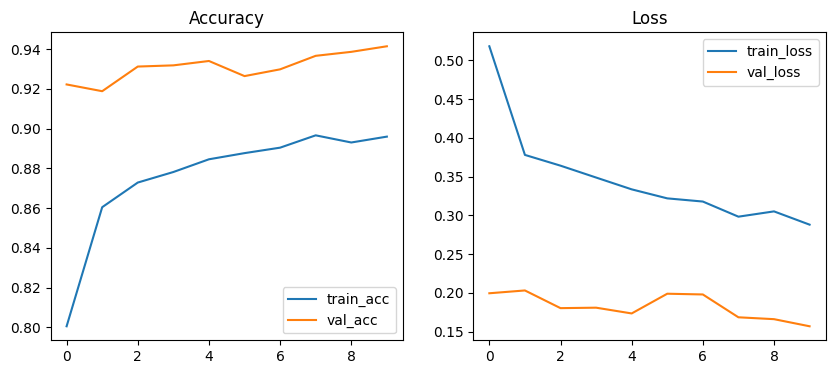

In [15]:
# ========================
# 8️⃣ Save model & plot training curves
# ========================
os.makedirs('../models', exist_ok=True)
model.save('../models/vgg16_catdog.h5')
print("✅ Model saved to ../models/vgg16_catdog.h5")

# 绘制训练/验证曲线
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()
